In [9]:
%cd segment-anything-2

[Errno 2] No such file or directory: 'segment-anything-2'
/home/vik0t/hackaton/segment-anything-2


In [10]:
import os
import random
import pandas as pd
import json
import cv2
import torch
import torch.nn.utils
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.model_selection import train_test_split
 
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

In [11]:
def set_seeds():
    SEED_VALUE = 42
    random.seed(SEED_VALUE)
    np.random.seed(SEED_VALUE)
    torch.manual_seed(SEED_VALUE)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(SEED_VALUE)
        torch.cuda.manual_seed_all(SEED_VALUE)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = True
 
set_seeds()

In [66]:
#with open("/home/vik0t/hackaton/segment-anything-2/gray_val.json", "r") as f:
#  val_data = json.load(f)

with open("/home/vik0t/hackaton/segment-anything-2/gray_train.json", "r") as f:
  train_data = json.load(f)
data_path = '/home/vik0t/hackaton/segment-anything-2/data1/train/images'

In [48]:
ent = train_data['annotations'][0]
for i in range(len(train_data['images'])):
   if train_data['images'][i]['id'] == ent['id']:
     ind=i
     break
print(train_data['images'][ind])

{'id': 8263, 'file_name': 'b104904482c09c144c29ba7fbf61ffe7.JPG', 'width': 1344, 'height': 693}


{'id': 238, 'file_name': '06a5c13bfa4c3705610e262cf7ed3f1b.JPG', 'width': 1344, 'height': 693}
{'id': 240, 'image_id': 238, 'category_id': 0, 'bbox': [1136.3331909179688, 324.999673461914, 83.33333587646484, 80.250146484375], 'area': 6687.512411117926, 'iscrowd': 0, 'segmentation': [[1147.3, 323.4, 1146.6, 324.09999999999997, 1145.8999999999999, 324.09999999999997, 1145.1999999999998, 324.79999999999995, 1144.5, 324.79999999999995, 1143.8, 325.5, 1143.1, 325.5, 1143.1, 336.0, 1142.3999999999999, 336.7, 1142.3999999999999, 338.79999999999995, 1141.6999999999998, 339.5, 1141.6999999999998, 341.59999999999997, 1141.0, 342.29999999999995, 1141.0, 344.4, 1139.6, 345.79999999999995, 1139.6, 346.5, 1138.1999999999998, 347.9, 1138.1999999999998, 348.59999999999997, 1137.5, 349.29999999999995, 1137.5, 350.7, 1136.8, 351.4, 1136.8, 353.5, 1136.1, 354.2, 1136.1, 356.29999999999995, 1135.3999999999999, 357.0, 1135.3999999999999, 359.79999999999995, 1136.1, 360.5, 1136.1, 362.59999999999997, 1136.8

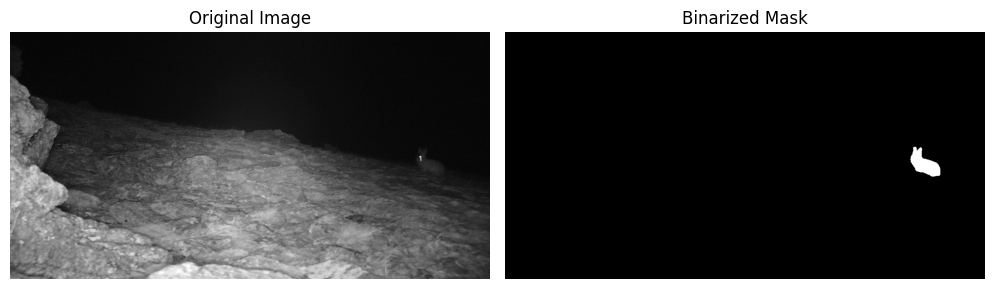

In [72]:
ent = train_data['annotations'][np.random.randint(len(train_data['annotations']))]
for i in range(len(train_data['images'])):
   if train_data['images'][i]['id'] == ent['image_id']:
     ind=i
     break
print(train_data['images'][ind])
print(ent)
visualize_data=True

image_path = train_data['images'][ind]['file_name']
image_path = os.path.join(data_path, image_path)
Img = cv2.imread(image_path)[..., ::-1]  # Convert BGR to RGB
binary_mask = np.zeros((693, 1344), dtype=np.uint8)
for pts in ent['segmentation']:
  # Шаг 1: Разделить на пары (x, y)
  points = [[pts[i], pts[i + 1]] for i in range(0, len(pts), 2)]
  # Шаг 2: Обернуть в список (даже если один полигон)
  polygon = [points]
  # Шаг 3: Преобразовать в NumPy массив с типом int32
  pts_array = np.array(polygon, dtype=np.int32)
  cv2.fillPoly(binary_mask, pts_array , color=1)
# Erode the combined binary mask to avoid boundary points
eroded_mask = cv2.erode(binary_mask, np.ones((5, 5), np.uint8), iterations=1)
points = []
# Get all coordinates inside the eroded mask and choose random points
coords = np.argwhere(eroded_mask > 0)
if len(coords) > 0:
    yx = coords[np.random.randint(len(coords))]  # Randomly select a point
    points.append([yx[1], yx[0]])  # Append in [x, y] format (col, row)
points = np.array(points)
binary_mask = np.expand_dims(binary_mask, axis=-1)  # Now shape is (1024, 1024, 1) (1,1024,1024)
binary_mask = binary_mask.transpose((2, 0, 1))
points = np.expand_dims(points, axis=1)
if visualize_data:
  plt.figure(figsize=(15, 5))
  plt.subplot(1, 3, 1)
  plt.title('Original Image')
  plt.imshow(Img)
  plt.axis('off')
  plt.subplot(1, 3, 2)
  plt.title('Binarized Mask')
  plt.imshow(binary_mask.transpose((1,2,0)), cmap='gray')
  plt.axis('off')
  #plt.subplot(1, 3, 3)
  #plt.title('Binarized Mask with Points')
  #plt.imshow(binary_mask.transpose((1,2,0)), cmap='gray')
  #colors = list(mcolors.TABLEAU_COLORS.values())
  #for i, point in enumerate(points):
  #    plt.scatter(point[0], point[1], c=colors[i % len(colors)], s=100)
  #plt.axis('off')
  plt.tight_layout()
  plt.show()

In [73]:
import cv2
def read_batch(json_data, data_path, visualize_data=False):
   # Select a random entry
  ent = json_data['annotations'][np.random.randint(len(json_data['annotations']))]
  for i in range(len(json_data['images'])):
     if json_data['images'][i]['id'] == ent['image_id']:
        ind=i
        break
  image_path = json_data['images'][ind]['file_name']
  image_path = os.path.join(data_path, image_path)
  Img = cv2.imread(image_path)[..., ::-1]  # Convert BGR to RGB
  binary_mask = np.zeros((693, 1344), dtype=np.uint8)
  for pts in ent['segmentation']:
    # Шаг 1: Разделить на пары (x, y)
    points = [[pts[i], pts[i + 1]] for i in range(0, len(pts), 2)]

    # Шаг 2: Обернуть в список (даже если один полигон)
    polygon = [points]

    # Шаг 3: Преобразовать в NumPy массив с типом int32
    pts_array = np.array(polygon, dtype=np.int32)
    cv2.fillPoly(binary_mask, pts_array , color=1)

  # Erode the combined binary mask to avoid boundary points
  eroded_mask = cv2.erode(binary_mask, np.ones((5, 5), np.uint8), iterations=1)

  points = []
  # Get all coordinates inside the eroded mask and choose random points
  coords = np.argwhere(eroded_mask > 0)
  if len(coords) > 0:
      yx = coords[np.random.randint(len(coords))]  # Randomly select a point
      points.append([yx[1], yx[0]])  # Append in [x, y] format (col, row)

  points = np.array(points)
  binary_mask = np.expand_dims(binary_mask, axis=-1)  # Now shape is (1024, 1024, 1) (1,1024,1024)
  binary_mask = binary_mask.transpose((2, 0, 1))
  points = np.expand_dims(points, axis=1)

  if visualize_data:
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.title('Original Image')
    plt.imshow(Img)
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title('Binarized Mask')
    plt.imshow(binary_mask.transpose((1,2,0)), cmap='gray')
    plt.axis('off')

    #plt.subplot(1, 3, 3)
    #plt.title('Binarized Mask with Points')
    #plt.imshow(binary_mask.transpose((1,2,0)), cmap='gray')
    #colors = list(mcolors.TABLEAU_COLORS.values())
    #for i, point in enumerate(points):
    #    plt.scatter(point[0], point[1], c=colors[i % len(colors)], s=100)
    #plt.axis('off')

    plt.tight_layout()
    plt.show()

  # Return the image, binarized mask, points, and number of masks
  return Img, binary_mask, points, 1

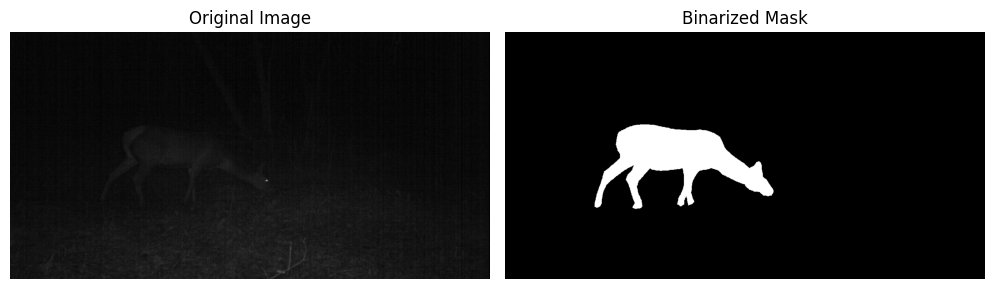

In [100]:
Img1, masks1, points1, num_masks = read_batch(train_data, data_path, visualize_data=True)